In [1]:
import math
from tensorboardX import SummaryWriter
sess = None

In [2]:
import tensorflow as tf
import collections
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.8)
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
'''
from gym import envs
env = gym.make('SpaceInvadersNoFrameskip-v4')
env = gym.wrappers.Monitor(env,directory='video_dddqn02',force=True)
env.reset()
for _ in range(1300):
    obs, _, done, _ = env.step(1)
    #env.render()
    obs = np.array(obs)
    if done:
        print('done')
        break
env.close()
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');
'''


"\nfrom gym import envs\nenv = gym.make('SpaceInvadersNoFrameskip-v4')\nenv = gym.wrappers.Monitor(env,directory='video_dddqn02',force=True)\nenv.reset()\nfor _ in range(1300):\n    obs, _, done, _ = env.step(1)\n    #env.render()\n    obs = np.array(obs)\n    if done:\n        print('done')\n        break\nenv.close()\nplt.imshow(obs[:,:,0],interpolation='none',cmap='gray');\n"

6
(84, 84, 4)


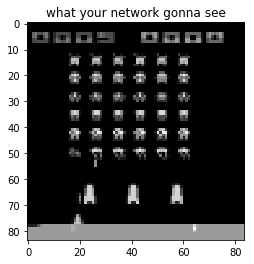

In [4]:
from wrappers import make_atari_deepmind
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#env_name = "PongNoFrameskip-v4"
#env_name = "BreakoutNoFrameskip-v4"
env_name = "SpaceInvadersNoFrameskip-v4"
env = make_atari_deepmind(env_name, skip=3)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print(n_actions)
obs = env.reset()
obs, r, done, _ = env.step(2)
#print(obs.shape)
#print(is_done)
done = False
for _ in range(130):
    obs, _, done, _ = env.step(1)
    #env.render()
    obs = np.array(obs)
    if done:
        print('done')
        break
plt.title("what your network gonna see")
print (obs.shape)
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');

In [5]:

from dqnagent import DQNAgent
import tr_helpers
import networks


#agent.epsilon = 0.5

breakout_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 8,
    'BATCH_SIZE' : 32 * 2,
    'EPSILON' : 0,
    'MIN_EPSILON' : 0,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'ENDDDQN2',
    'IS_DOUBLE' : False,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 420,
    'NUM_STEPS_FILL_BUFFER' : 1000,
    'REPLAY_BUFFER_TYPE' : 'normal',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'STEPS_NUM' : 1,
    'NETWORK' : networks.AtariNoisyDuelingDQN(),
    'REWARD_SHAPER' : tr_helpers.DefaultRewardsShaper(),
    'EPISODES_TO_LOG' : 20, 
    'LIVES_REWARD' : 5,
    'ATOMS_NUM' : 1
    }

spaceinviders_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 8,
    'BATCH_SIZE' : 32 * 2,
    'EPSILON' : 0,
    'MIN_EPSILON' : 0,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'ENDDDQN2',
    'IS_DOUBLE' : False,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 5000,
    'NUM_STEPS_FILL_BUFFER' : 1000,
    'REPLAY_BUFFER_TYPE' : 'normal',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'STEPS_NUM' : 3,
    'NETWORK' : networks.AtariNoisyDuelingDQN(),
    'REWARD_SHAPER' : tr_helpers.DefaultRewardsShaper(clip_value=3, scale_value = 0.05),
    'EPISODES_TO_LOG' : 15, 
    'LIVES_REWARD' : 3,
    'ATOMS_NUM' : 1
    }

pong_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 4,
    'BATCH_SIZE' : 32 * 4,
    'EPSILON' : .90,
    'MIN_EPSILON' : 0.02,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'PongDDDQN',
    'IS_DOUBLE' : True,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 20,
    'NUM_STEPS_FILL_BUFFER' : 10000,
    'REPLAY_BUFFER_TYPE' : 'normal',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'NETWORK' : networks.AtariDuelingDQN(),
    'STEPS_NUM' : 1,
    'REWARD_SHAPER' : tr_helpers.DefaultRewardsShaper(),
    'EPISODES_TO_LOG' : 10, 
    'LIVES_REWARD' : 1,
    'ATOMS_NUM' : 1
    }
agent = DQNAgent(env, sess, env_name, config = spaceinviders_dddqn_config)
#agent.restore('nn/ENDDDQN2SpaceInvadersNoFrameskip-v4')
#agent.epsilon = 0.02

In [ ]:
env.reset()
agent.train()

Frames per seconds:  215.43128127225293
Frames per seconds:  220.31855943747095
Frames per seconds:  219.5479743770385
saving next best rewards:  230.0
Frames per seconds:  218.3989042314194
Frames per seconds:  215.0729356686763
Frames per seconds:  219.78728187274118
Frames per seconds:  219.69106363204193
Frames per seconds:  216.7932503103966
Frames per seconds:  207.9808167718173
Frames per seconds:  215.99958924943832
Frames per seconds:  218.82598715113963
Frames per seconds:  220.12519565921903
Frames per seconds:  219.98147128720848
Frames per seconds:  218.87556938617158
Frames per seconds:  218.11244176289475
Frames per seconds:  218.16142879657374
Frames per seconds:  215.07281435659277
Frames per seconds:  217.02937197369715
Frames per seconds:  216.51389880799516
saving next best rewards:  235.0
Frames per seconds:  208.7155152963849
Frames per seconds:  191.82529485513277
Frames per seconds:  207.35131210151786
Frames per seconds:  202.67884906666487
saving next best rew

In [ ]:
import wrappers
#print(env.unwrapped.get_action_meanings())
def evaluate(env,t_max=10000):
    rewards = []
    env._max_episode_steps = 9999
    print('reset')
    #env = env.old_env
    s = env.reset()
    reward = 0
    for it in range(t_max):
        #nv.render()
        #e.render()
        qvalues = agent.get_qvalues([s])
        action = np.argmax(qvalues)
        s, r, done, _ = env.step(action)
        reward += r
        
            
        if done:
            break       
        
    return reward

import gym.wrappers

env_monitor = wrappers.make_atari_deepmind_test(env_name, noop_max=30, skip=3)
env_monitor = wrappers.ReallyDoneWrapper(env_monitor)
env_monitor = gym.wrappers.Monitor(env_monitor,directory='video_dddqn05',force=True)

sessions = [print('reward:', evaluate(env_monitor)) for _ in range(1)]
env_monitor.close()

In [ ]:
#tf.reset_default_graph()
#agent = DQNAgent(env, sess, ExperienceBuffer(EXP_BUFFER_CAPACITY), env_name, config = dqn_config)

In [ ]:
#env.reset()
#agent.train()